# Initialisation

In [38]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import keras

from PIL import Image

from keras import layers
from keras.applications import mobilenet_v2
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras.layers import Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import seaborn as sns

import time
import pathlib

from ultralytics import YOLO

import torch

In [2]:
keras.version()

'3.12.0'

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
# Constants
DATA_SRC = 'garbage_classification/'
MODEL_PATH = "./garbage_classification.keras"
FINETUNED_MODEL_PATH = "./garbage_classification_finetuned.keras"
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

TRAIN_SIZE = 0.7
VAL_SIZE = 0.2
TEST_SIZE = 0.1

BATCH_SIZE = 32
EPOCHS = 20
SEED = 123

# Model Preparation

In [5]:
# Create the dataset (ds)
garbage_directory = pathlib.Path(DATA_SRC)
ds = image_dataset_from_directory(
    directory=garbage_directory,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
)

Found 15515 files belonging to 12 classes.


In [6]:
classes = ds.class_names
len_classes = len(classes)
print(f"Detected classes: {classes}\nClass size: {len_classes}")

Detected classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Class size: 12


In [7]:
# Apply the split to the dataset. 
total_batches = tf.data.experimental.cardinality(ds).numpy()
train_size = int(total_batches * TRAIN_SIZE)
val_size = int(total_batches * VAL_SIZE)
test_size = total_batches - train_size - val_size

if train_size + val_size + test_size != total_batches:
    print("ERROR: Invalid split sizes.")
    exit(1)

print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")
print(f"Total batches found: {total_batches}")

Train size: 339
Validation size: 97
Test size: 49
Total batches found: 485


In [8]:
# Split the dataset into train, validation and test. Each taking their respective sizes
train_ds = ds.take(train_size)
leftover_ds = ds.skip(train_size)
val_ds = leftover_ds.take(val_size)
test_ds = leftover_ds.skip(val_size)

print(f"Train size: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test size: {tf.data.experimental.cardinality(test_ds).numpy()}")

Train size: 339
Validation size: 97
Test size: 49


In [9]:
# Alter the image in various ways so that the model is more robust
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

In [ ]:
# Early stopping implemented here to ensure best efficiency in training. Ergo no overfitting occurs in the model
# After a certain point the model can lose acc and validation
early_stop = EarlyStopping(patience=4, verbose=1, monitor='val_categorical_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights=True)

# Plateau will help to optimize the training  passively as the epochs go by.
plateau = ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    patience=3,
    factor=0.5,
    min_lr=1e-7,
    verbose=1
)

# This will actively monitor the learning process and save the best model.
checkpoint = ModelCheckpoint("garbage_classification_checkpoint.keras", monitor='val_categorical_accuracy', save_best_only=True,mode='max',verbose=1)

callbacks = [early_stop, plateau, checkpoint]

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
def augment_ds(ds, augment=False):
    if augment:
        ds = ds.map(lambda a, b: (data_augmentation(a, training=True), b),
        num_parallel_calls=AUTOTUNE
        
        )
    ds = ds.cache()
    if augment:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [12]:
train_ds = augment_ds(train_ds, augment=True)
val_ds = augment_ds(val_ds, augment=False)
test_ds = augment_ds(test_ds, augment=False)

In [13]:
def preprocess_model_input(img):
    return mobilenet_v2.preprocess_input(img)

# Model Training

In [39]:
# Here we use transfer learning
mobile_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet',
)
# Freeze the base model
mobile_model.trainable = False

model = Sequential()

model.add(keras.Input(shape=IMG_SHAPE))
# Preprocssessing to handle the image sizes
model.add(Lambda(preprocess_model_input))
model.add(mobile_model)
model.add(Flatten())
# model.add(GlobalAveragePooling2D())

#1
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# #2
# model.add(Dense(128,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(len_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,014,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,273,164 (23.93 MB)

 Trainable params: 4,015,052 (15.32 MB)

 Non-trainable params: 2,258,112 (8.61 MB)

In [75]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

model.save(MODEL_PATH)

Epoch 1/20


2025-12-10 04:21:35.157357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3931: Filling up shuffle buffer (this may take a while): 254 of 1000
2025-12-10 04:21:53.096576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3931: Filling up shuffle buffer (this may take a while): 312 of 1000
2025-12-10 04:22:00.957573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - categorical_accuracy: 0.6519 - loss: 1.1680
Epoch 1: val_categorical_accuracy improved from None to 0.90271, saving model to garbage_classification_checkpoint.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 94s 139ms/step - categorical_accuracy: 0.7585 - loss: 0.7889 - val_categorical_accuracy: 0.9027 - val_loss: 0.3010 - learning_rate: 0.0010
Epoch 2/20
338/339 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.8529 - loss: 0.4577
Epoch 2: val_categorical_accuracy improved from 0.90271 to 0.91527, saving model to garbage_classification_checkpoint.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - categorical_accuracy: 0.8606 - loss: 0.4336 - val_categorical_accuracy: 0.9153 - val_loss: 0.2585 - learning_rate: 0.0010
Epoch 3/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.8935 - loss: 0.3269
Epoch 3: val_categorical_accuracy improved from 0.91527 to 0.92010, saving model to garbage_classification_checkpoint.keras
339/339 ━

# Model Loading

In [25]:
# If you would like to reload the model, run all the code in Initialisation and Model Preparation. 
# This will load the test generator and the model
try:
    keras.config.enable_unsafe_deserialization()
    model = load_model(MODEL_PATH, custom_objects={'preprocess_model_input': preprocess_model_input})
except Exception as e:
    print("ERROR: Model has not been loaded.", e)
    exit(1)

# Model Validation

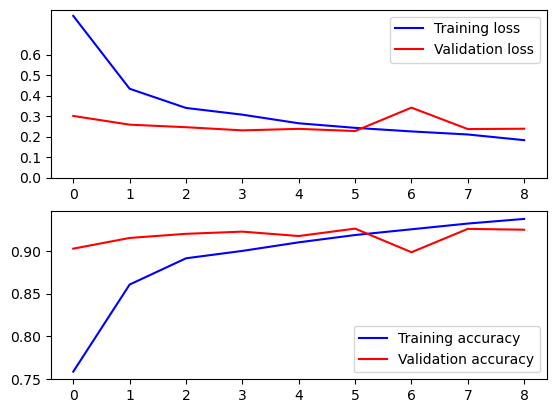

In [91]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.show()

In [54]:
loss, accuracy = model.evaluate(test_ds, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - categorical_accuracy: 0.9367 - loss: 0.1939
Test Loss: 0.1939
Test Accuracy: 93.67%


In [55]:
y_pred_probs = model.predict(test_ds)

true_labels = []

for test_images, test_labels in test_ds:
    true_labels.extend(tf.argmax(test_labels, axis=1).numpy())

pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = true_labels
y_pred = pred_labels


49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step


2025-12-10 15:41:53.420384: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

     battery       0.99      0.91      0.95        93
  biological       0.97      0.98      0.98       102
 brown-glass       0.97      0.88      0.92        69
   cardboard       0.99      0.91      0.95       102
     clothes       0.98      1.00      0.99       495
 green-glass       0.91      0.89      0.90        54
       metal       0.82      0.86      0.84        83
       paper       0.89      0.95      0.92       109
     plastic       0.83      0.74      0.79       101
       shoes       0.96      0.98      0.97       197
       trash       0.97      0.90      0.93        77
 white-glass       0.76      0.88      0.82        81

    accuracy                           0.94      1563
   macro avg       0.92      0.91      0.91      1563
weighted avg       0.94      0.94      0.94      1563



<Axes: >

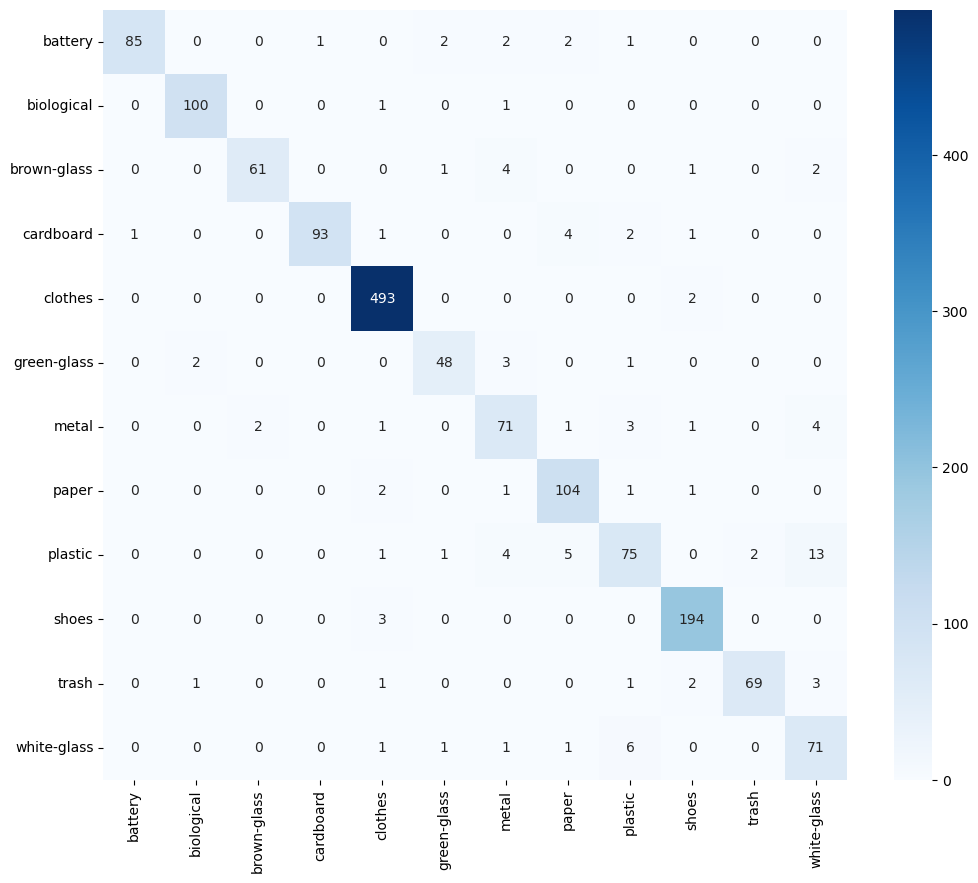

In [57]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)

# Fine-Tuning

In [46]:
def freeze_model(model, layers_to_freeze):
    base_model = model.layers[1]
    base_model.trainable = True
    for layer in base_model.layers[:layers_to_freeze]:
        layer.trainable = False

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-5),
        metrics=['categorical_accuracy']
    )
    return model

In [ ]:
# Unfreeze x layers
new_model = freeze_model(model, 120)
new_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,900 (10.00 MB)

 Trainable params: 363,148 (1.39 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [52]:
# Train
history_tuned = new_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

model.save(FINETUNED_MODEL_PATH)

Epoch 1/20


2025-12-10 15:33:38.622825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 95 of 1000
2025-12-10 15:33:49.179938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 168 of 1000
2025-12-10 15:34:09.557401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 302 of 1000
2025-12-10 15:34:14.007232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-12-10 15:34:14.022006: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269120 bytes after encountering the first element of size 19269120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-12-10 15:34:19.386429: I external/l

339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - categorical_accuracy: 0.8792 - loss: 0.3911
Epoch 1: val_categorical_accuracy improved from None to 0.94104, saving model to garbage_classification_checkpoint.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 185s 372ms/step - categorical_accuracy: 0.8788 - loss: 0.3957 - val_categorical_accuracy: 0.9410 - val_loss: 0.1829 - learning_rate: 1.0000e-05
Epoch 2/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - categorical_accuracy: 0.8760 - loss: 0.3932
Epoch 2: val_categorical_accuracy improved from 0.94104 to 0.94137, saving model to garbage_classification_checkpoint.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - categorical_accuracy: 0.8774 - loss: 0.3897 - val_categorical_accuracy: 0.9414 - val_loss: 0.1824 - learning_rate: 1.0000e-05
Epoch 3/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - categorical_accuracy: 0.8876 - loss: 0.3716
Epoch 3: val_categorical_accuracy improved from 0.94137 to 0.94201, saving model to garbage_classification_checkpoint.ker

# Implementation with OpenCV

In [36]:
CAM_INDEX = 0
video_stream = cv2.VideoCapture(CAM_INDEX)
video_stream.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
video_stream.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
if not video_stream.isOpened():
    print("ERROR: Could not open camera.")
    exit(1)
print("Press 'ESC' to quit")

CONFIDENCE_THRESHOLD = 0.65
EPSILON = 1e-10
yolo = YOLO("yolov8s.pt")

while True:
    # Capture frame-by-frame
    ret, frame = video_stream.read()

    

    if not ret:
        print("ERROR: Can't receive frame.")
        break
    
    # stream_size = cv2.resize(frame, IMG_SIZE)
    # stream_rgb = cv2.cvtColor(stream_size, cv2.COLOR_BGR2RGB)
    # img_batch = np.expand_dims(stream_rgb, axis=0)

    objects = yolo.predict(frame,verbose=False,imgsz=480,conf=0.30)

    for o in objects:
        for box in o.boxes:
            if yolo.names[int(box.cls[0])] == "person":
                continue
            
            x1,y1,x2,y2 = box.xyxy[0].cpu().numpy().astype(int)

            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)

            cropped_dims = frame[y1:y2, x1:x2]

            if cropped_dims.size > 0:
                cropped_resized = cv2.resize(cropped_dims, IMG_SIZE)
                cropped_rgb_pixels = cv2.cvtColor(cropped_resized, cv2.COLOR_BGR2RGB)
                batch = np.expand_dims(cropped_rgb_pixels, axis=0)
                
                models_prediction = model.predict(batch, verbose=0)
    
                models_prediction_class_idx = np.argmax(models_prediction[0])
                models_prediction_class_name = classes[models_prediction_class_idx]
                confidence = models_prediction[0][models_prediction_class_idx]
                
                entropy = np.sum(
                    models_prediction[0] * np.log(models_prediction[0] + EPSILON))
                max_e = np.log(len_classes)
                normal_entropy = entropy / max_e 

                ENTROPY_LIMIT = -0.45  

                is_confident = (
                    confidence >= CONFIDENCE_THRESHOLD and 
                    normal_entropy <= 0.7
                )
                

                if is_confident:
                    text = f"{models_prediction_class_name} ({confidence * 100:.2f})%"
                else:
                    text = "UNKNOWN"
                cv2.putText(frame, text, (x1,y1 - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2 )

  
    cv2.imshow("Garbage Classification", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        print("Exiting the program...")
        break
    elif key == ord("s"):
        print("Saving the image...")
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        filename = f"image_{models_prediction_class_name}_{timestamp}.jpg"
        cv2.imwrite(filename, frame)
        

# When everything done, release the capture
video_stream.release()
cv2.destroyAllWindows()
print("Exiting the program...")

Press 'ESC' to quit
Exiting the program...
Exiting the program...
